匯入函式庫和資料

In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

import torch
import torchvision
from torchvision import transforms, models
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset, random_split
import os
import glob

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mimg
# %matplotlib inline  ← 不支援 PyTorch，註解掉
import cv2

from os import listdir, makedirs, getcwd, remove
from os.path import isfile, join, abspath, exists, isdir, expanduser
from PIL import Image
from pathlib import Path
from skimage.io import imread
from skimage.transform import resize
from sklearn.model_selection import train_test_split

# 檢查 GPU
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print("Using device:", device)



Using device: mps


In [2]:
INPUT_PATH = "./data/realwaste-main/RealWaste"
print(os.listdir(INPUT_PATH))

['Paper', 'Metal', 'Cardboard', 'Food Organics', 'Glass', 'Vegetation', 'Textile Trash', 'Miscellaneous Trash', 'Plastic']


In [3]:
glass = Path(INPUT_PATH + '/Glass').glob('*.jpg')
metal = Path(INPUT_PATH + '/Metal').glob('*.jpg')
foodorga = Path(INPUT_PATH + '/Food Organics').glob('*.jpg')
mistrash = Path(INPUT_PATH + '/Miscellaneous Trash').glob('*.jpg')
plastic = Path(INPUT_PATH + '/Plastic').glob('*.jpg')
paper = Path(INPUT_PATH + '/Paper').glob('*.jpg')
textrash = Path(INPUT_PATH + '/Textile Trash').glob('*.jpg')
cardboard = Path(INPUT_PATH + '/Cardboard').glob('*.jpg')
vegetation = Path(INPUT_PATH + '/Vegetation').glob('*.jpg')

In [4]:
galss_data = [(image, 0) for image in glass]
metal_data = [(image, 1) for image in metal]
foodorga_data = [(image, 2) for image in foodorga]
mistrash_data = [(image, 3) for image in mistrash]
plastic_data = [(image, 4) for image in plastic]
paper_data = [(image, 5) for image in paper]
textrash_data = [(image, 6) for image in textrash]
cardboard_data = [(image, 7) for image in cardboard]
vegetation_data = [(image, 8) for image in vegetation]

total_data = galss_data + metal_data + foodorga_data + mistrash_data + plastic_data + paper_data + textrash_data + cardboard_data + vegetation_data
total_data = pd.DataFrame(total_data, columns=['image', 'label'])

In [5]:
train_val_df, test_df = train_test_split(total_data, test_size=0.10, random_state=42)

In [6]:
train_df, val_df = train_test_split(train_val_df, test_size=1/6, random_state=42)

訓練資料集處理

In [7]:
train_df = train_df.sample(frac=1., random_state=100).reset_index(drop=True)

Total :  3563
label
4    691
1    568
3    385
5    380
7    341
8    321
0    315
2    307
6    255
Name: count, dtype: int64


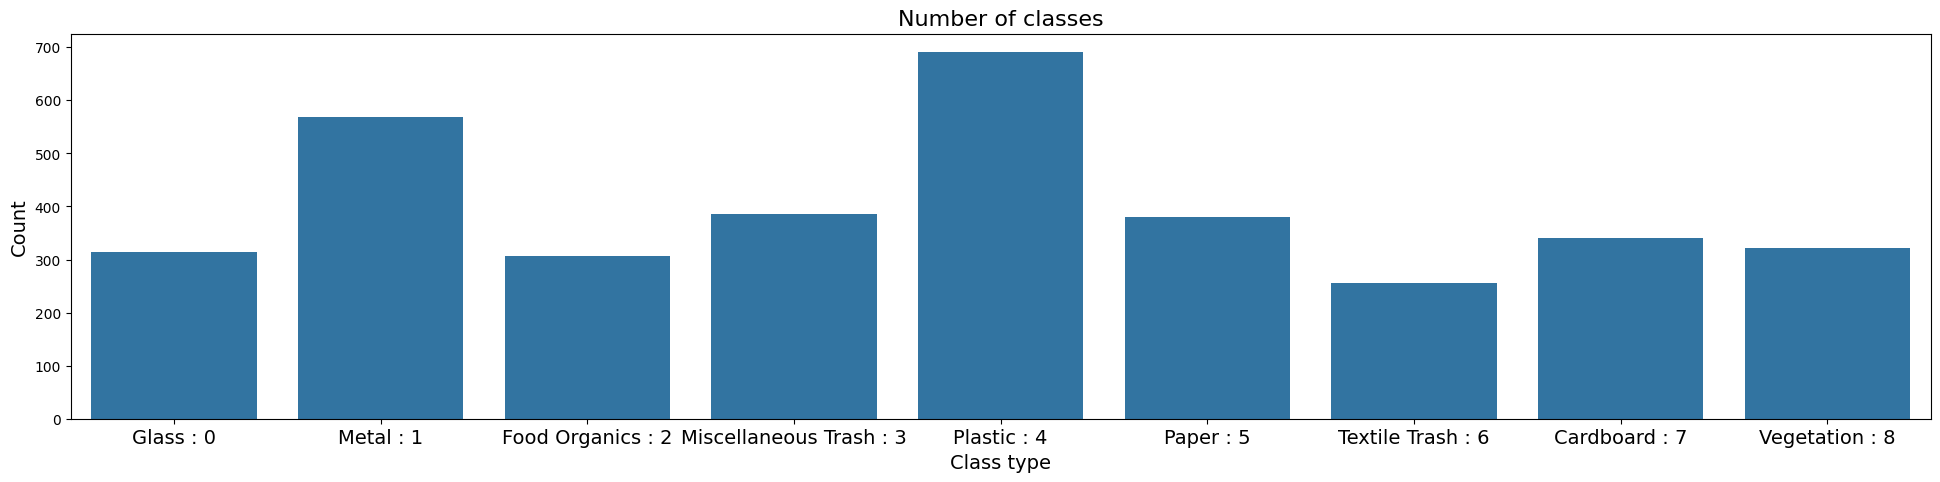

In [8]:
count_result = train_df['label'].value_counts()
print('Total : ', len(train_df))
print(count_result)

plt.figure(figsize=(24,5))
sns.countplot(x = 'label', data =  train_df)
plt.title('Number of classes', fontsize=16)
plt.xlabel('Class type', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(range(len(count_result.index)),
           ['Glass : 0', 'Metal : 1', 'Food Organics : 2', 'Miscellaneous Trash : 3', 'Plastic : 4', 'Paper : 5', 'Textile Trash : 6', 'Cardboard : 7', 'Vegetation : 8'],
           fontsize=14)
plt.show()


In [9]:
class WasteDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.data = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image_path = str(self.data.iloc[idx]['image'])
        label = self.data.iloc[idx]['label']
        image = cv2.imread(image_path)
        image = cv2.resize(image, (224, 224))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = Image.fromarray(image)
        if self.transform:
            image = self.transform(image)
        return image, label


In [10]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)  # 可依需求調整
])

train_dataset = WasteDataset(train_df, transform=transform)
x_train = DataLoader(train_dataset, batch_size=16, shuffle=True)

print("Total number of training examples:", len(train_dataset))


Total number of training examples: 3563


In [11]:
# 不需 one-hot 編碼，PyTorch 的 CrossEntropyLoss 會自動處理
# y_train = tf.keras.utils.to_categorical(y_train,9) ← 可省略


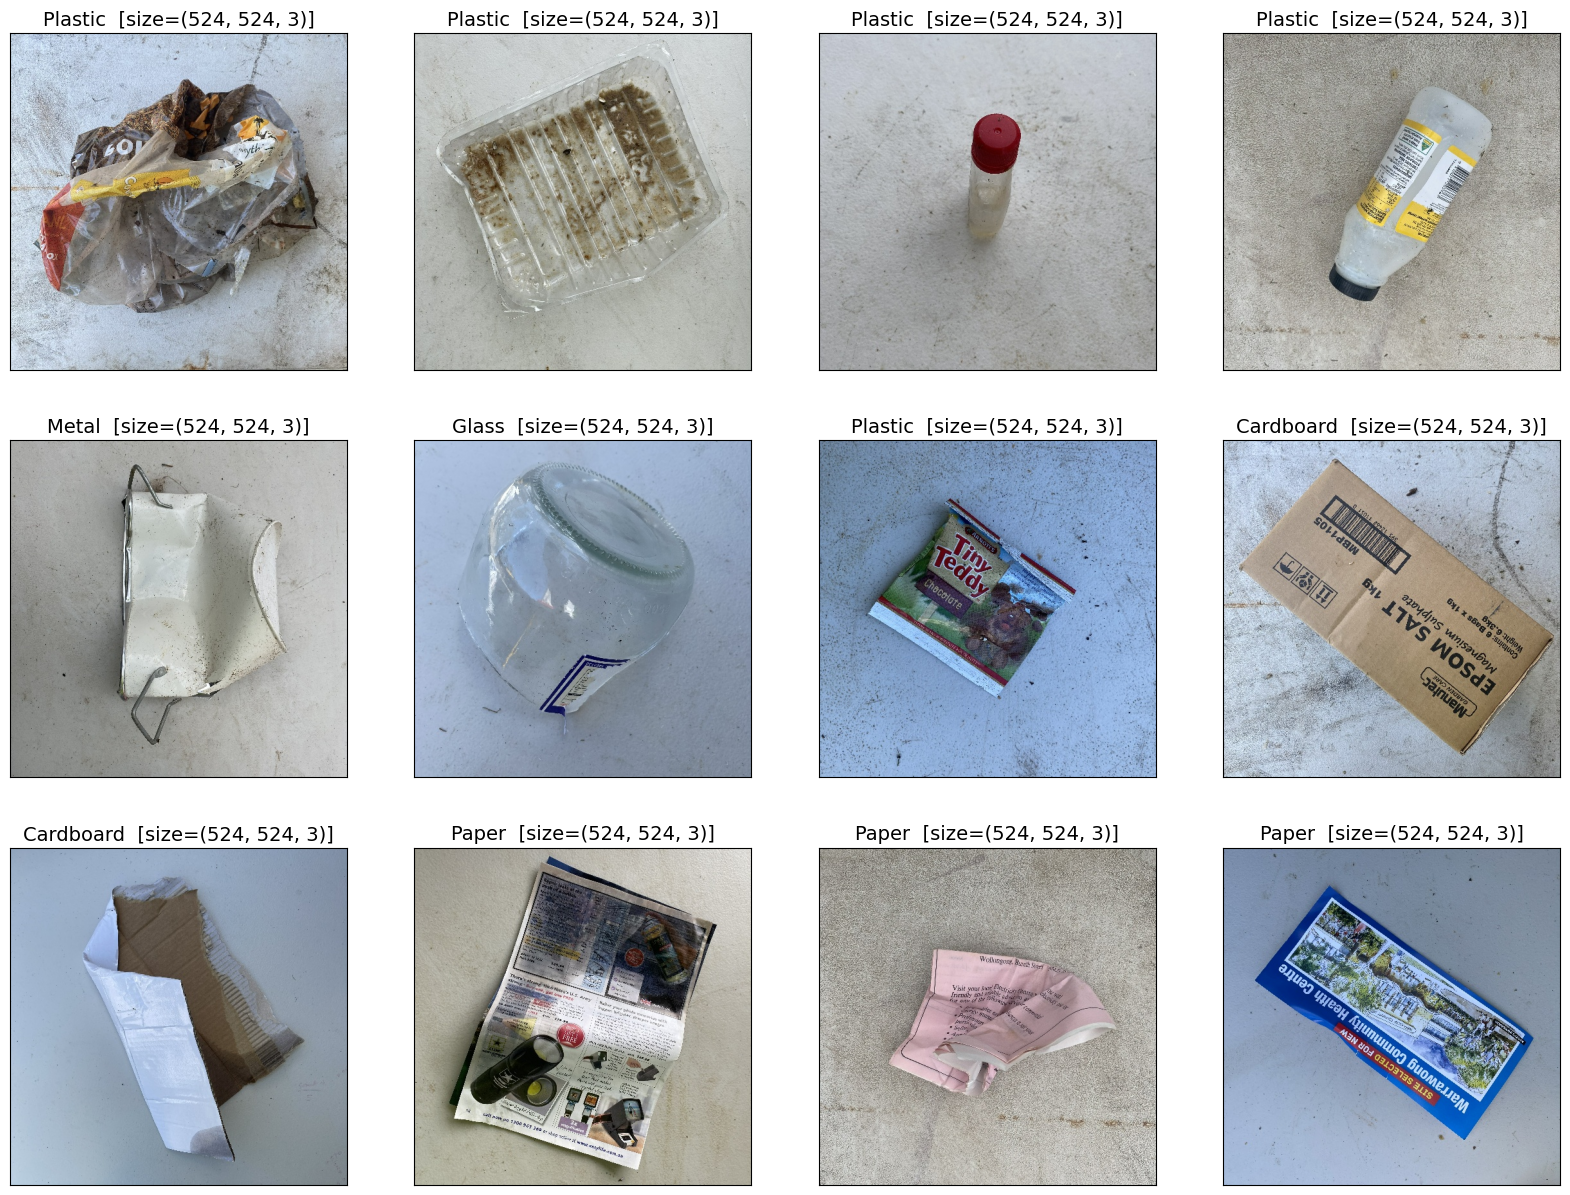

In [12]:
fig, ax = plt.subplots(3, 4, figsize=(20,15))
for i, axi in enumerate(ax.flat):
    image = imread(train_df.image[i])
    axi.imshow(image, cmap='bone')
    axi.set_title(('Glass' if train_df.label[i] == 0
                   else 'Metal' if train_df.label[i] == 1
                   else 'Food Organics' if train_df.label[i] == 2
                   else 'Miscellaneous Trash' if train_df.label[i] == 3
                   else 'Plastic' if train_df.label[i] == 4
                   else 'Paper' if train_df.label[i] == 5
                   else 'Textile Trash' if train_df.label[i] == 6
                   else 'Cardboard' if train_df.label[i] == 7
                   else 'Vegetation')
                  + '  [size=' + str(image.shape) +']',
                  fontsize=14)
    axi.set(xticks=[], yticks=[])


Validation資料集處理

In [13]:
val_df = val_df.sample(frac=1., random_state=100).reset_index(drop=True)

Total :  713
label
4    140
1    134
7     79
3     73
5     64
2     63
8     62
0     59
6     39
Name: count, dtype: int64


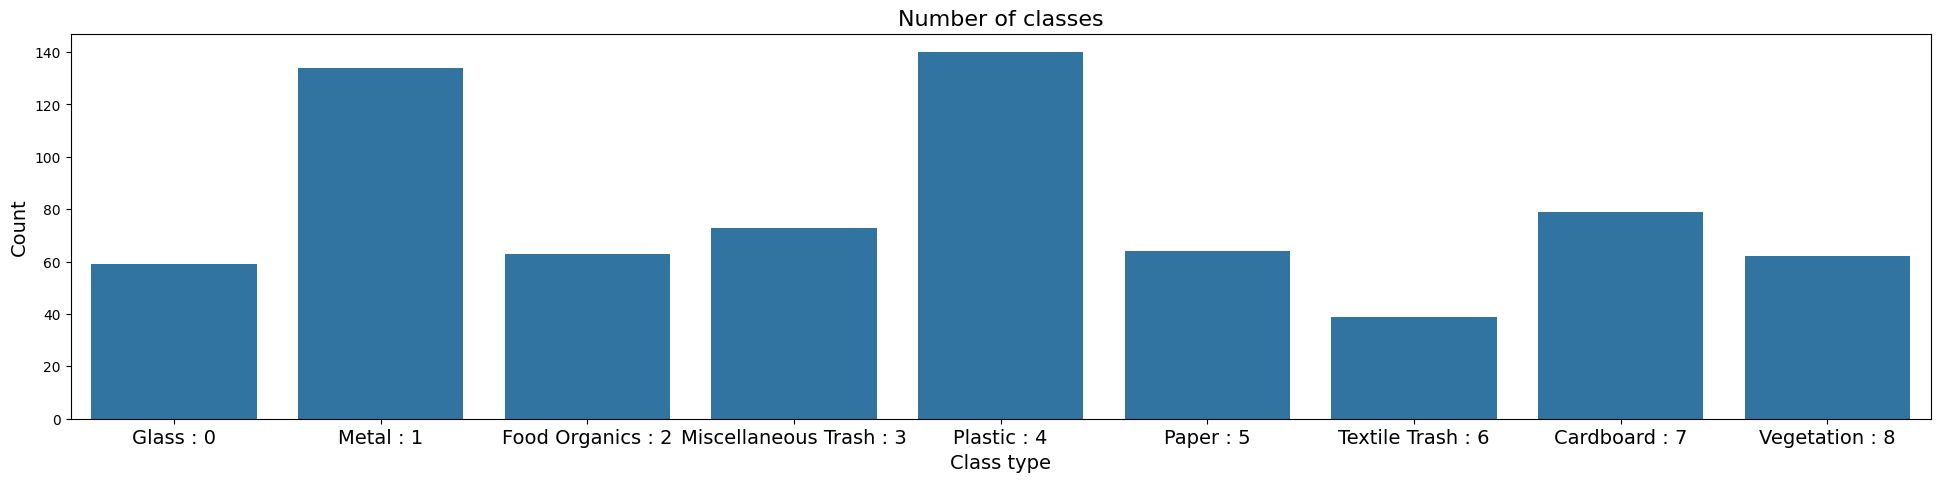

In [14]:
count_result = val_df['label'].value_counts()
print('Total : ', len(val_df))
print(count_result)

plt.figure(figsize=(24,5))
sns.countplot(x = 'label', data =  val_df)
plt.title('Number of classes', fontsize=16)
plt.xlabel('Class type', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(range(len(count_result.index)),
           ['Glass : 0', 'Metal : 1', 'Food Organics : 2', 'Miscellaneous Trash : 3', 'Plastic : 4', 'Paper : 5', 'Textile Trash : 6', 'Cardboard : 7', 'Vegetation : 8'],
           fontsize=14)
plt.show()


In [15]:
test_df = test_df.sample(frac=1., random_state=100).reset_index(drop=True)


測試資料集處理

Total :  476
label
4    90
1    88
5    56
8    53
0    46
2    41
7    41
3    37
6    24
Name: count, dtype: int64


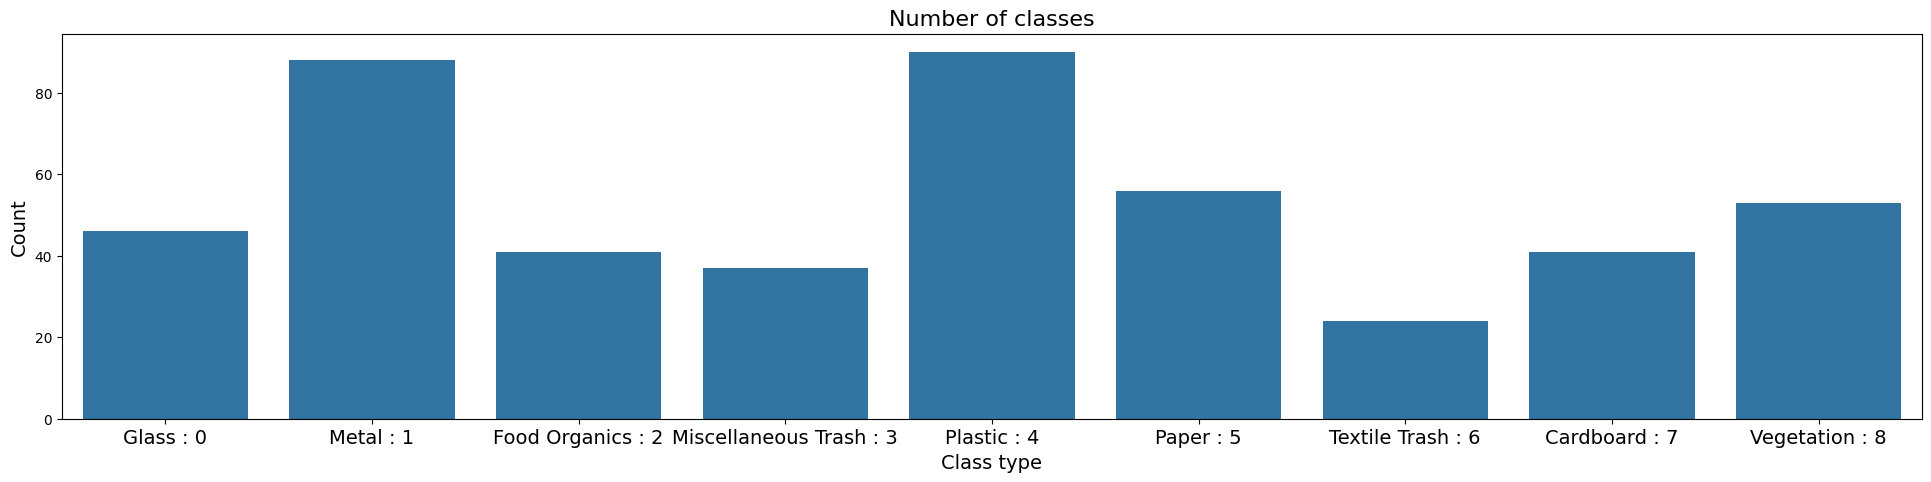

In [16]:
count_result = test_df['label'].value_counts()
print('Total : ', len(test_df))
print(count_result)

plt.figure(figsize=(24,5))
sns.countplot(x = 'label', data =  test_df)
plt.title('Number of classes', fontsize=16)
plt.xlabel('Class type', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(range(len(count_result.index)),
           ['Glass : 0', 'Metal : 1', 'Food Organics : 2', 'Miscellaneous Trash : 3', 'Plastic : 4', 'Paper : 5', 'Textile Trash : 6', 'Cardboard : 7', 'Vegetation : 8'],
           fontsize=14)
plt.show()


In [17]:
test_dataset = WasteDataset(test_df, transform=transform)
x_test = DataLoader(test_dataset, batch_size=16, shuffle=False)

print("Total number of test examples:", len(test_dataset))


Total number of test examples: 476


Test accuracy

mobilenet_v2 : 0.8445378151260504
efficientnet_b0 : 0.8529411764705882
efficientnet_b1 :
efficientnet_v2_s :
convnext_tiny :

In [18]:
#model = models.mobilenet_v2(pretrained=True)
#model = models.efficientnet_b0(pretrained=True)
model = models.efficientnet_b1(pretrained=True)
#model = models.efficientnet_v2_s(weights=models.EfficientNet_V2_S_Weights.DEFAULT)
#model = models.convnext_tiny(weights=models.ConvNeXt_Tiny_Weights.DEFAULT)


in_features = model.classifier[1].in_features
model.classifier[1] = nn.Linear(in_features, 9)

model = model.to(device)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B1_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B1_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b1_rwightman-bac287d4.pth" to /Users/johnnychao/.cache/torch/hub/checkpoints/efficientnet_b1_rwightman-bac287d4.pth
100%|██████████| 30.1M/30.1M [00:00<00:00, 56.5MB/s]


In [19]:
for param in model.features.parameters():
    param.requires_grad = False


In [20]:
base_learning_rate = 0.001


In [21]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=base_learning_rate)


In [22]:
batch_size = 16
initial_epochs = 50


In [23]:
from tqdm import tqdm

for epoch in range(initial_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in tqdm(x_train):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)
    
    acc = correct / total
    print(f"Epoch {epoch+1}/{initial_epochs} - Loss: {running_loss:.4f}, Accuracy: {acc:.4f}")


 95%|█████████▌| 212/223 [00:24<00:01,  8.50it/s]


KeyboardInterrupt: 

In [ ]:
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in x_test:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

test_accuracy = correct / total
print('Test accuracy :', test_accuracy)


Test accuracy : 0.8529411764705882
